## Lipid maps pulldown prep

"LIPID Metabolites And Pathways Strategy (LIPID MAPS) is a multi-institutional supported website and database that provides access to a large number of globally used lipidomics resources." (["About us" page](https://www.lipidmaps.org/about/information))

The [LIPID MAPS Structure Database (LMSD)](https://www.lipidmaps.org/databases/lmsd/download) provides chemical formula in SMILES format of over 50,000 lipids.

A/B hydrolase protein 2090 may act on lipids. What if we were to use AlphaFold 3 to give us a clue as to which type of lipids this enzyme may be acting on?

In [2]:
import os
from pathlib import Path
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors
from scipy.stats import entropy

cwd = os.getcwd()
if cwd.endswith('notebook'):
    os.chdir('..')
    cwd = os.getcwd()

In [3]:
sns.set_palette('colorblind')
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.8)
plt.rcParams['font.family'] = 'Helvetica'

palette = sns.color_palette().as_hex()

base_folder = Path(os.path.expanduser('~')) / 'Documents' / 'Chahrazad'
assert base_folder.is_dir()

## Load Lipid Maps Structure Database (LMSD)

In [33]:
lmsd_path = (base_folder / 'lipid_maps' / 'lipids.sdf').resolve().as_posix()
lipids = Chem.SDMolSupplier(lmsd_path)

In [34]:
for lipid in lipids:
    break

print('Available attributes:')
attributes = list(lipid.GetPropNames())
attributes

Available attributes:


['LM_ID',
 'NAME',
 'SYSTEMATIC_NAME',
 'CATEGORY',
 'MAIN_CLASS',
 'EXACT_MASS',
 'FORMULA',
 'INCHI_KEY',
 'INCHI',
 'SMILES',
 'ABBREVIATION',
 'SYNONYMS',
 'PUBCHEM_CID',
 'CHEBI_ID']

In [35]:
for attribute in lipid.GetPropNames():
    print(f'{attribute}:', lipid.GetProp(attribute))

LM_ID: LMFA00000001
NAME: 2-methoxy-12-methyloctadec-17-en-5-ynoyl anhydride
SYSTEMATIC_NAME: 2-methoxy-12-methyloctadec-17-en-5-ynoyl anhydride
CATEGORY: Fatty Acyls [FA]
MAIN_CLASS: Other Fatty Acyls [FA00]
EXACT_MASS: 626.491025
FORMULA: C40H66O5
INCHI_KEY: VOGBKCAANIAXCI-UHFFFAOYSA-N
INCHI: InChI=1S/C40H66O5/c1-7-9-11-23-29-35(3)31-25-19-15-13-17-21-27-33-37(43-5)39(41)45-40(42)38(44-6)34-28-22-18-14-16-20-26-32-36(4)30-24-12-10-8-2/h7-8,35-38H,1-2,9-16,19-20,23-34H2,3-6H3
SMILES: C(C(OC)CCC#CCCCCCC(C)CCCCC=C)(=O)OC(C(OC)CCC#CCCCCCC(C)CCCCC=C)=O
ABBREVIATION: FA 40:7;O3
SYNONYMS: Acetylenic acids
PUBCHEM_CID: 10930192
CHEBI_ID: 178363


In [36]:
mass_list = []
molecules = []
for lipid in lipids:
    if lipid is not None and 'SMILES' in lipid.GetPropNames():
        lm_id = lipid.GetProp('LM_ID')
        mass = float(lipid.GetProp('EXACT_MASS'))

        assert not pd.isnull(mass) and mass > 0

        mass_list.append((lm_id, mass))
        molecules.append(lipid)

print(f'Number of lipids in LMSD: {len(mass_list):,}')

[16:08:42] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 5 ignored
[16:08:42] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 5 ignored
[16:08:42] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 5 ignored
[16:08:42] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 5 ignored
[16:08:42] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 5 ignored
[16:08:42] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 7 ignored.
[16:08:42] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 7 ignored.
[16:08:42] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 7 ignored.
[16:08:42] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 7 ignored.
[16:08:43] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 3 ignored.
[16:0

Number of lipids in LMSD: 48,233


[16:08:45] Warning: conflicting stereochemistry - bond wedging contradiction - at atom 56 ignored
[16:08:45] Warning: conflicting stereochemistry - bond wedging contradiction - at atom 56 ignored


### Export as csv

In [37]:
def export_lipids_as_table(molecules):
    columns = [
        'LM_ID',
        'NAME',
        'CATEGORY',
        'MAIN_CLASS',
        'SUB_CLASS',
        'EXACT_MASS',
        'FORMULA',
        'PUBCHEM_CID',
    ]
    data = {c: [] for c in columns}
    data['SMILES'] = []
    for molecule in molecules:
        available_attributes = set(molecule.GetPropNames())
        for attr in columns:
            if attr in available_attributes:
                val = molecule.GetProp(attr)
            else:
                val = None

            data[attr].append(val)

        data['SMILES'].append(Chem.MolToSmiles(molecule))

    return pd.DataFrame.from_dict(data).set_index('LM_ID', drop=True)

In [38]:
lipids_df = export_lipids_as_table(molecules)
lipids_df.head()

,NAME,CATEGORY,MAIN_CLASS,SUB_CLASS,EXACT_MASS,FORMULA,PUBCHEM_CID,SMILES
LM_ID,,,,,,,,
LMFA00000001,2-methoxy-12-methyloctadec-17-en-5-ynoyl anhyd...,Fatty Acyls [FA],Other Fatty Acyls [FA00],None,626.491025,C40H66O5,10930192,C=CCCCCC(C)CCCCCC#CCCC(OC)C(=O)OC(=O)C(CCC#CCC...
LMFA00000002,Serratamic acid,Fatty Acyls [FA],Other Fatty Acyls [FA00],None,275.173274,C13H25NO5,42607281,CCCCCCC[C@H](O)CC(=O)N[C@@H](CO)C(=O)O
LMFA00000003,N-(3-(hexadecanoyloxy)-heptadecanoyl)-L-ornithine,Fatty Acyls [FA],Other Fatty Acyls [FA00],None,638.559773,C38H74N2O5,42607282,CCCCCCCCCCCCCCCC(=O)OC(CCCCCCCCCCCCCC)CC(=O)N[...
LMFA00000005,N-(3-(15-methyl-hexadecanoyloxy)-13-methyl-tet...,Fatty Acyls [FA],Other Fatty Acyls [FA00],None,625.528139,C37H71NO6,42607283,CC(C)CCCCCCCCCCCCCC(=O)OC(CCCCCCCCCCCC(C)C)CC(...
LMFA00000006,Lysine-containing siolipin,Fatty Acyls [FA],Other Fatty Acyls [FA00],None,684.565253,C39H76N2O7,42607284,CC(C)CCCCCCCCCCC(O)CC(=O)N[C@@H](CCCCN)C(=O)OC...


In [39]:
lipids_df.to_csv(base_folder / 'lipid_maps' / 'lipids.csv')

## Sample 100 lipids

We'll start by running AF3 on a subset of 100 lipids. This should help estimate runtime on the full 50k DB.

We want the distribution of molecular weights in the sample to be as close as possible to the full distribution. We'll generate 100 independent samples, compute the KL divergence vs the entire distribution and keep the sample with the smallest KL divergence.

In [40]:
n_samples = 100
n_generations = 100
n_bins = 20
seed = 123
rng = np.random.default_rng(seed)

all_masses = np.array([m for _, m in mass_list], dtype=np.float32)
bin_counts, _ = np.histogram(all_masses, bins=n_bins, density=False)
full_distribution = bin_counts / np.sum(bin_counts)

samples = []
for _ in range(n_generations):
    s = rng.choice(mass_list, size=n_samples, replace=False)
    sample_masses = np.array([m for _, m in s], dtype=np.float32)
    s_bin_counts, _ = np.histogram(sample_masses, bins=n_bins, density=False)
    sample_distribution = s_bin_counts / np.sum(s_bin_counts)

    kl_divergence = entropy(full_distribution, sample_distribution)

    samples.append((s, kl_divergence))

sample_tuples = sorted(samples, key=lambda t: t[1])
print(f'Best KL divergence  : {sample_tuples[0][1]}')
print(f'Worst KL divergence : {sample_tuples[-1][1]}')

sample = sample_tuples[0][0]

Best KL divergence  : 0.4250911413508963
Worst KL divergence : inf


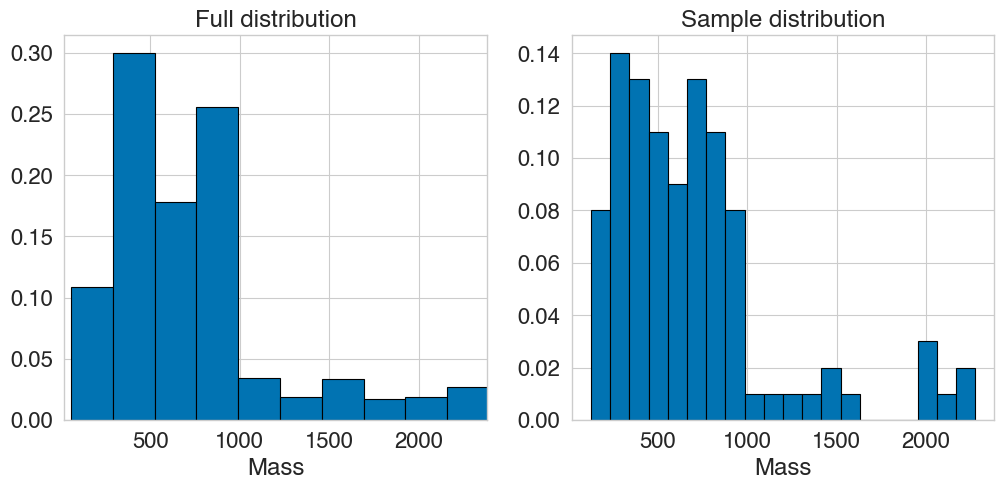

In [41]:
f, axes = plt.subplots(1, 2, figsize=(12, 5))
ax1, ax2 = axes.flatten()

sample_masses = np.array([m for _, m in sample], dtype=np.float32)

for ax, data in [(ax1, all_masses), (ax2, sample_masses)]:
    bin_counts, bin_edges = np.histogram(data, bins=n_bins, density=False)
    bin_probabilities = bin_counts / np.sum(bin_counts)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.bar(bin_centers, bin_probabilities, width=np.diff(bin_edges), edgecolor='black', align='center')

ax1.set_xlim(ax2.get_xlim());

ax1.set_title('Full distribution');
ax2.set_title('Sample distribution');

ax1.set_xlabel('Mass');
ax2.set_xlabel('Mass');

### Export subset

In [42]:
sample_ids = {lm_id for lm_id, _ in sample}
samples_df = lipids_df.loc[sorted(sample_ids)]
samples_df.head()

,NAME,CATEGORY,MAIN_CLASS,SUB_CLASS,EXACT_MASS,FORMULA,PUBCHEM_CID,SMILES
LM_ID,,,,,,,,
LMFA01020032,(+)-C27-Phthienoic acid,Fatty Acyls [FA],Fatty Acids and Conjugates [FA01],Branched fatty acids [FA0102],408.396730,C27H52O2,5282613,CCCCCCCCCCCCCCCCCCC(C)CC(C)/C=C(\C)C(=O)O
LMFA01030109,"9,12-hexadecadienoic acid",Fatty Acyls [FA],Fatty Acids and Conjugates [FA01],Unsaturated fatty acids [FA0103],252.208930,C16H28O2,5282787,CCC/C=C/C/C=C/CCCCCCCC(=O)O
LMFA01030372,8Z-eicosenoic acid,Fatty Acyls [FA],Fatty Acids and Conjugates [FA01],Unsaturated fatty acids [FA0103],310.287180,C20H38O2,5312523,CCCCCCCCCCC/C=C\CCCCCCC(=O)O
LMFA01050220,28-hydroxy-octacosanoic acid,Fatty Acyls [FA],Fatty Acids and Conjugates [FA01],Hydroxy fatty acids [FA0105],440.422945,C28H56O3,5312786,O=C(O)CCCCCCCCCCCCCCCCCCCCCCCCCCCO
LMFA01050225,6-hydroxy-heptanoic acid,Fatty Acyls [FA],Fatty Acids and Conjugates [FA01],Hydroxy fatty acids [FA0105],146.094295,C7H14O3,5312788,CC(O)CCCCC(=O)O


In [43]:
samples_df.to_csv(base_folder / 'lipid_maps' / 'lipids_sample.csv')

## Results on sample

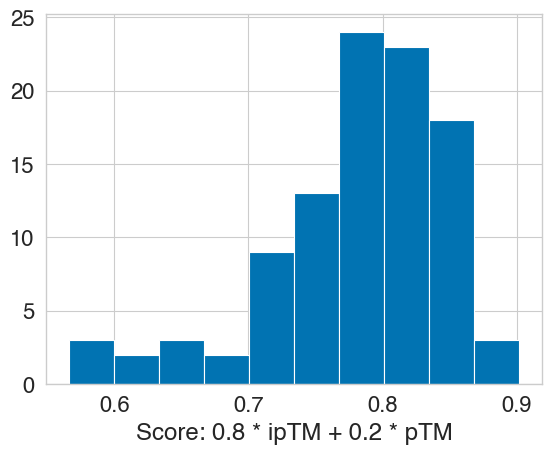

In [44]:
results_df = pd.read_csv(base_folder / 'lipid_maps' / 'lipids_pulldown_sample_results.csv')
ax = results_df['confidence'].hist(bins=10)
ax.set_xlabel('Score: 0.8 * ipTM + 0.2 * pTM');

In [45]:
results_df.head(20)

,id,fraction_disordered,has_clash,iptm,ptm,ranking_score,confidence
0,hydrolase_2090__lmfa07010858,0.09,0.0,0.91,0.87,0.95,0.902
1,hydrolase_2090__lmgp03030001,0.09,0.0,0.90,0.88,0.94,0.896
2,hydrolase_2090__lmgp01011701,0.09,0.0,0.89,0.87,0.93,0.886
3,hydrolase_2090__lmfa02000381,0.09,0.0,0.87,0.86,0.92,0.868
4,hydrolase_2090__lmgp02010674,0.09,0.0,0.86,0.87,0.91,0.862
5,hydrolase_2090__lmgp03010340,0.09,0.0,0.86,0.87,0.91,0.862
6,hydrolase_2090__lmgp04010818,0.09,0.0,0.86,0.87,0.91,0.862
7,hydrolase_2090__lmgp04010134,0.09,0.0,0.86,0.87,0.91,0.862
8,hydrolase_2090__lmgp02010924,0.09,0.0,0.86,0.87,0.90,0.862
9,hydrolase_2090__lmgp04010895,0.09,0.0,0.86,0.86,0.90,0.860


## Full pulldown

Creating 8 random partitions.

In [48]:
n_partitions = 8
all_ids = sorted(set(lipids_df.index))

print(f'Number of IDs     = {len(all_ids):,}')
print(f'IDs per partition = {len(all_ids) // n_partitions:,}')

random.seed(123)
random.shuffle(all_ids)

partitions = np.array_split(all_ids, n_partitions)

output_folder = base_folder / 'lipid_maps' / 'partitions'
output_folder.mkdir(exist_ok=True)

for i, partition_ids in enumerate(partitions):
    partition_df = lipids_df.loc[partition_ids]
    partition_df.to_csv(output_folder / f'lipids_partition_{str(i+1).zfill(2)}.csv')

Number of IDs     = 48,233
IDs per partition = 6,029


### Results

In [61]:
res_df = pd.read_csv(base_folder / 'lipid_maps' / 'lipids_pulldown_results.csv', index_col='id')

lipids_df = pd.read_csv(base_folder / 'lipid_maps' / 'lipids.csv', index_col='LM_ID')

res_df['LM_ID'] = [pid.split('__')[1].strip().upper() for pid in res_df.index]

res_df = pd.merge(
    res_df.reset_index().set_index('LM_ID'),
    lipids_df,
    how='left',
    on='LM_ID',
)

res_df['rank'] = res_df.reset_index().index + 1

res_df.head()

,id,fraction_disordered,has_clash,iptm,ptm,ranking_score,confidence,NAME,CATEGORY,MAIN_CLASS,SUB_CLASS,EXACT_MASS,FORMULA,PUBCHEM_CID,SMILES,rank
LM_ID,,,,,,,,,,,,,,,,
LMST01010341,hydrolase_2090__lmst01010341,0.0,0.0,0.96,0.96,0.96,0.960,Cryptogenin,Sterol Lipids [ST],Sterols [ST01],Cholesterol and derivatives [ST0101],430.30831,C27H42O4,21117640.0,C[C@@H](CO)CCC(=O)[C@@H](C)[C@H]1C(=O)C[C@H]2[...,1
LMFA07010825,hydrolase_2090__lmfa07010825,0.0,0.0,0.95,0.96,0.95,0.952,Cyclohexyl pentanoate,Fatty Acyls [FA],Fatty esters [FA07],Wax monoesters [FA0701],184.14633,C11H20O2,73772.0,CCCCC(=O)OC1CCCCC1,2
LMFA11000630,hydrolase_2090__lmfa11000630,0.0,0.0,0.95,0.96,0.95,0.952,1-methylpropyl-cyclohexane,Fatty Acyls [FA],Hydrocarbons [FA11],NaN,140.15650,C10H20,23468.0,CCC(C)C1CCCCC1,3
LMFA11000702,hydrolase_2090__lmfa11000702,0.0,0.0,0.95,0.95,0.95,0.950,3-Ethylpentane,Fatty Acyls [FA],Hydrocarbons [FA11],NaN,100.12520,C7H16,12048.0,CCC(CC)CC,4
LMFA01030195,hydrolase_2090__lmfa01030195,0.0,0.0,0.95,0.95,0.95,0.950,Crotonic acid,Fatty Acyls [FA],Fatty Acids and Conjugates [FA01],Unsaturated fatty acids [FA0103],86.03678,C4H6O2,637090.0,C/C=C/C(=O)O,5


In [7]:
assert res_df['has_clash'].sum() == 0

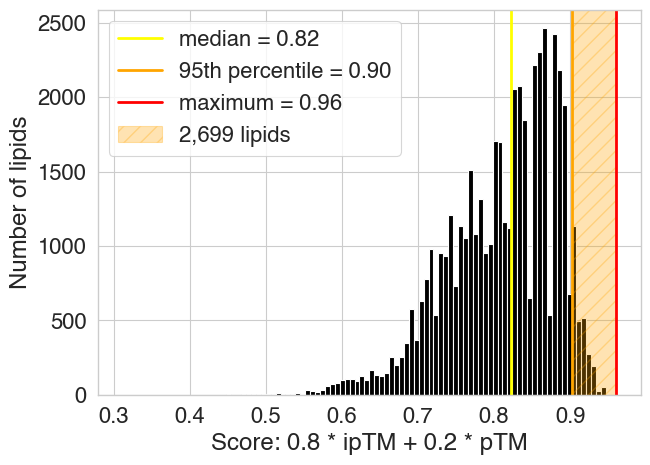

In [174]:
f, ax = plt.subplots(1, 1, figsize=(7, 5))
ax = res_df['confidence'].hist(bins=100, ax=ax, color='black')
ax.set_xlabel('Score: 0.8 * ipTM + 0.2 * pTM');
ax.set_ylabel('Number of lipids');

stats = res_df['confidence'].describe()
median = stats['50%']
q95 = res_df['confidence'].quantile(0.95)
n_95 = res_df[res_df['confidence'] >= q95].shape[0]
max_value = stats['max']

ax.axvline(median, color='yellow', label=f'median = {median:.02f}', linewidth=2);
ax.axvline(q95, color='orange', label=f'95th percentile = {q95:.02f}', linewidth=2);
ax.axvline(max_value, color='red', label=f'maximum = {max_value:.02f}', linewidth=2);
ax.axvspan(q95, max_value, color='orange', hatch='//', alpha=0.3, label=f'{n_95:,} lipids')
ax.legend();

In [141]:
stats

count    48233.000000
mean         0.808965
std          0.072121
min          0.312000
25%          0.762000
50%          0.822000
75%          0.866000
max          0.960000
Name: confidence, dtype: float64

In [62]:
res_df[res_df['confidence'] > 0.95]

,id,fraction_disordered,has_clash,iptm,ptm,ranking_score,confidence,NAME,CATEGORY,MAIN_CLASS,SUB_CLASS,EXACT_MASS,FORMULA,PUBCHEM_CID,SMILES,rank
LM_ID,,,,,,,,,,,,,,,,
LMST01010341,hydrolase_2090__lmst01010341,0.0,0.0,0.96,0.96,0.96,0.960,Cryptogenin,Sterol Lipids [ST],Sterols [ST01],Cholesterol and derivatives [ST0101],430.30831,C27H42O4,21117640.0,C[C@@H](CO)CCC(=O)[C@@H](C)[C@H]1C(=O)C[C@H]2[...,1
LMFA07010825,hydrolase_2090__lmfa07010825,0.0,0.0,0.95,0.96,0.95,0.952,Cyclohexyl pentanoate,Fatty Acyls [FA],Fatty esters [FA07],Wax monoesters [FA0701],184.14633,C11H20O2,73772.0,CCCCC(=O)OC1CCCCC1,2
LMFA11000630,hydrolase_2090__lmfa11000630,0.0,0.0,0.95,0.96,0.95,0.952,1-methylpropyl-cyclohexane,Fatty Acyls [FA],Hydrocarbons [FA11],NaN,140.15650,C10H20,23468.0,CCC(C)C1CCCCC1,3


In [83]:
g = res_df[['MAIN_CLASS', 'EXACT_MASS', 'confidence']].groupby('MAIN_CLASS').agg(['mean', 'median', 'std', 'count']).sort_values(('confidence', 'mean'), ascending=False)
g.head(10)

EXACT_MASS                          \
                                            mean      median         std   
MAIN_CLASS                                                                 
Phosphonosphingolipids [SP04]         634.510060  642.510059   15.634526   
Polyether antibiotics [PK09]          248.514533  184.146330  146.498137   
Fatty aldehydes [FA06]                196.590600  196.182715   64.497337   
Glyceropyrophosphates [GP11]          767.462816  767.462816   18.395843   
Halogenated acetogenins [PK02]        415.822287  389.983002   57.325831   
Glycerophosphoglycerols [GP04]        765.552873  774.541088   70.347986   
Amphoteric glycosphingolipids [SP08]  541.292071  541.292071         NaN   
Other Sphingolipids [SP00]            620.198009  603.453261   49.313056   
Fatty alcohols [FA05]                 233.643420  212.214015  106.249141   
Glycerophosphonoethanolamines [GP17]  701.535942  701.535942         NaN   

                                           confidence                         
                                     count       mean median       std count  
MAIN_CLASS                                                                    
Phosphonosphingolipids [SP04]            3   0.903333  0.900  0.013317     3  
Polyether antibiotics [PK09]            41   0.901610  0.926  0.059306    41  
Fatty aldehydes [FA06]                 270   0.886785  0.892  0.020805   270  
Glyceropyrophosphates [GP11]             2   0.884000  0.884  0.000000     2  
Halogenated acetogenins [PK02]          15   0.884000  0.894  0.030622    15  
Glycerophosphoglycerols [GP04]        1216   0.883956  0.884  0.021472  1216  
Amphoteric glycosphingolipids [SP08]     1   0.882000  0.882       NaN     1  
Other Sphingolipids [SP00]              11   0.879273  0.876  0.015957    11  
Fatty alcohols [FA05]                  504   0.877139  0.884  0.035902   504  
Glycerophosphonoethanolamines [GP17]     1   0.876000  0.876       NaN     1

In [85]:
g = res_df[['CATEGORY', 'EXACT_MASS', 'confidence']].groupby('CATEGORY').agg(['mean', 'median', 'std', 'count']).sort_values(('confidence', 'mean'), ascending=False)
g.head(10)

EXACT_MASS                                  \
                                  mean       median         std  count   
CATEGORY                                                                 
Fatty Acyls [FA]            349.871444   328.224975  185.678108  10896   
Glycerophospholipids [GP]   873.021393   787.645492  279.428316  10039   
Sterol Lipids [ST]          476.011738   432.323960  146.456423   3979   
Polyketides [PK]            486.094098   436.188590  184.277286   7174   
Prenol Lipids [PR]          506.291403   500.313790  257.552489   2487   
Sphingolipids [SP]         1573.622036  1663.903272  658.012657   4557   
Glycerolipids [GL]          871.913890   894.767640  119.591538   7753   
Saccharolipids [SL]        2098.839119  2177.911670  316.635149   1348   

                          confidence                          
                                mean median       std  count  
CATEGORY                                                      
Fatty Acyls [FA]            0.844534  0.844  0.046021  10896  
Glycerophospholipids [GP]   0.842073  0.858  0.052630  10039  
Sterol Lipids [ST]          0.825828  0.830  0.049991   3979  
Polyketides [PK]            0.822169  0.826  0.054288   7174  
Prenol Lipids [PR]          0.802394  0.808  0.082270   2487  
Sphingolipids [SP]          0.770915  0.784  0.082431   4557  
Glycerolipids [GL]          0.749148  0.744  0.045824   7753  
Saccharolipids [SL]         0.639644  0.630  0.058371   1348

In [64]:
res_df[res_df['MAIN_CLASS'] == 'Glycerophosphoglycerols [GP04]'].head()

,id,fraction_disordered,has_clash,iptm,ptm,ranking_score,confidence,NAME,CATEGORY,MAIN_CLASS,SUB_CLASS,EXACT_MASS,FORMULA,PUBCHEM_CID,SMILES,rank
LM_ID,,,,,,,,,,,,,,,,
LMGP04110003,hydrolase_2090__lmgp04110003,0.0,0.0,0.93,0.96,0.93,0.936,NaN,Glycerophospholipids [GP],Glycerophosphoglycerols [GP04],"1-acyl,2-alkylglycerophosphoglycerols [GP0411]",776.499223,C44H73O9P,42607488.0,O=C(CCCCCC1CCC2C(C1)C1C3CCC3C21)OC[C@H](COP(=O...,77
LMGP04110001,hydrolase_2090__lmgp04110001,0.0,0.0,0.92,0.96,0.93,0.928,NaN,Glycerophospholipids [GP],Glycerophosphoglycerols [GP04],"1-acyl,2-alkylglycerophosphoglycerols [GP0411]",728.499223,C40H73O9P,42607486.0,CCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)(O)OC[C@@H](O...,261
LMGP04010032,hydrolase_2090__lmgp04010032,0.0,0.0,0.92,0.95,0.93,0.926,PG(10:0/10:0),Glycerophospholipids [GP],Glycerophosphoglycerols [GP04],Diacylglycerophosphoglycerols [GP0401],554.321988,C26H51O10P,9547126.0,CCCCCCCCCC(=O)OC[C@H](COP(=O)(O)OC[C@@H](O)CO)...,316
LMGP04010932,hydrolase_2090__lmgp04010932,0.0,0.0,0.92,0.95,0.92,0.926,PG(14:0/12:0),Glycerophospholipids [GP],Glycerophosphoglycerols [GP04],Diacylglycerophosphoglycerols [GP0401],638.415888,C32H63O10P,52927196.0,CCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)(O)OC[C@@H](O...,339
LMGP04050021,hydrolase_2090__lmgp04050021,0.0,0.0,0.92,0.95,0.92,0.926,"PG(18:4(6Z,9Z,12Z,15Z)/0:0)",Glycerophospholipids [GP],Glycerophosphoglycerols [GP04],Monoacylglycerophosphoglycerols [GP0405],504.248823,C24H41O9P,52927444.0,CC/C=C\C/C=C\C/C=C\C/C=C\CCCCC(=O)OC[C@@H](O)C...,351


<Axes: >

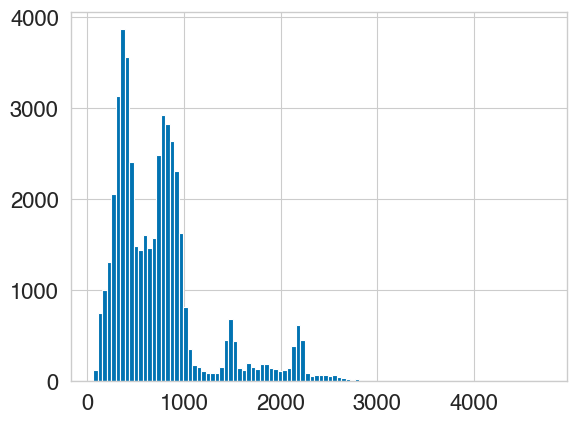

In [53]:
lipids_df['EXACT_MASS'].hist(bins=100)

In [54]:
res_df[res_df['EXACT_MASS'] > 200].head()

,id,fraction_disordered,has_clash,iptm,ptm,ranking_score,confidence,NAME,CATEGORY,MAIN_CLASS,SUB_CLASS,EXACT_MASS,FORMULA,PUBCHEM_CID,SMILES
LM_ID,,,,,,,,,,,,,,,
LMST01010341,hydrolase_2090__lmst01010341,0.0,0.0,0.96,0.96,0.96,0.960,Cryptogenin,Sterol Lipids [ST],Sterols [ST01],Cholesterol and derivatives [ST0101],430.308310,C27H42O4,21117640.0,C[C@@H](CO)CCC(=O)[C@@H](C)[C@H]1C(=O)C[C@H]2[...
LMFA01090138,hydrolase_2090__lmfa01090138,0.0,0.0,0.94,0.96,0.94,0.944,Ethyl 3-iodo-2E-acrylate,Fatty Acyls [FA],Fatty Acids and Conjugates [FA01],Halogenated fatty acids [FA0109],225.949082,C5H7IO2,639791.0,CCOC(=O)/C=C/I
LMST01160072,hydrolase_2090__lmst01160072,0.0,0.0,0.94,0.95,0.94,0.942,Withalongolide F,Sterol Lipids [ST],Sterols [ST01],Withanolides and derivatives [ST0116],424.261360,C27H36O4,56926117.0,CC1=C(CO)C(=O)O[C@@H]([C@@H](C)[C@H]2CC[C@H]3[...
LMPK13090039,hydrolase_2090__lmpk13090039,0.0,0.0,0.93,0.96,0.94,0.936,Lunularin,Polyketides [PK],Aromatic polyketides [PK13],"Diphenyl ethers, biphenyls, dibenzyls and stil...",214.099380,C14H14O2,181511.0,Oc1ccc(CCc2cccc(O)c2)cc1
LMPR0104030034,hydrolase_2090__lmpr0104030034,0.0,0.0,0.93,0.96,0.94,0.936,3Beta-Hydroxylissoclimide,Prenol Lipids [PR],Isoprenoids [PR01],C20 isoprenoids (diterpenes) [PR0104],399.181252,C20H30NO5Cl,11406911.0,C=C1[C@@H](O)C[C@H]2C(C)(C)[C@@H](O)[C@H](Cl)C...


In [211]:
all_count = res_df[['CATEGORY', 'confidence']].groupby('CATEGORY').count().rename(columns={'confidence': 'count_all'})

top_count = res_df[
    (res_df['confidence'] > q95)
][['CATEGORY', 'confidence']].groupby('CATEGORY').count().rename(columns={'confidence': 'count'})

top_df = pd.merge(
    top_count,
    all_count,
    on='CATEGORY',
    how='left',
)
top_df['ratio'] = top_df['count'] / top_df['count_all']
top_df = top_df.sort_values('count', ascending=False)
top_df.head(10)

,count,count_all,ratio
CATEGORY,,,
Fatty Acyls [FA],971,10896,0.089115
Glycerophospholipids [GP],299,10039,0.029784
Prenol Lipids [PR],294,2487,0.118215
Polyketides [PK],271,7174,0.037775
Sterol Lipids [ST],111,3979,0.027896
Sphingolipids [SP],8,4557,0.001756
Glycerolipids [GL],3,7753,0.000387


In [212]:
top_df.sort_values('ratio', ascending=False).head(10)

,count,count_all,ratio
CATEGORY,,,
Prenol Lipids [PR],294,2487,0.118215
Fatty Acyls [FA],971,10896,0.089115
Polyketides [PK],271,7174,0.037775
Glycerophospholipids [GP],299,10039,0.029784
Sterol Lipids [ST],111,3979,0.027896
Sphingolipids [SP],8,4557,0.001756
Glycerolipids [GL],3,7753,0.000387


In [92]:
res_df[res_df['CATEGORY'] == 'Glycerophospholipids [GP]'].head()

,id,fraction_disordered,has_clash,iptm,ptm,ranking_score,confidence,NAME,CATEGORY,MAIN_CLASS,SUB_CLASS,EXACT_MASS,FORMULA,PUBCHEM_CID,SMILES,rank
LM_ID,,,,,,,,,,,,,,,,
LMGP04110003,hydrolase_2090__lmgp04110003,0.0,0.0,0.93,0.96,0.93,0.936,NaN,Glycerophospholipids [GP],Glycerophosphoglycerols [GP04],"1-acyl,2-alkylglycerophosphoglycerols [GP0411]",776.499223,C44H73O9P,42607488.0,O=C(CCCCCC1CCC2C(C1)C1C3CCC3C21)OC[C@H](COP(=O...,77
LMGP01011581,hydrolase_2090__lmgp01011581,0.0,0.0,0.92,0.96,0.93,0.928,PC(18:0/13:0),Glycerophospholipids [GP],Glycerophosphocholines [GP01],Diacylglycerophosphocholines [GP0101],719.546507,C39H78NO8P,52922641.0,CCCCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)([O-])OCC...,256
LMGP02010562,hydrolase_2090__lmgp02010562,0.0,0.0,0.92,0.96,0.93,0.928,PE(17:1(9Z)/13:0),Glycerophospholipids [GP],Glycerophosphoethanolamines [GP02],Diacylglycerophosphoethanolamines [GP0201],661.468257,C35H68NO8P,52924263.0,CCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)(O)OCCN...,257
LMGP04110001,hydrolase_2090__lmgp04110001,0.0,0.0,0.92,0.96,0.93,0.928,NaN,Glycerophospholipids [GP],Glycerophosphoglycerols [GP04],"1-acyl,2-alkylglycerophosphoglycerols [GP0411]",728.499223,C40H73O9P,42607486.0,CCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)(O)OC[C@@H](O...,261
LMGP02010578,hydrolase_2090__lmgp02010578,0.0,0.0,0.92,0.96,0.93,0.928,PE(17:1(9Z)/19:1(9Z)),Glycerophospholipids [GP],Glycerophosphoethanolamines [GP02],Diacylglycerophosphoethanolamines [GP0201],743.546507,C41H78NO8P,52924279.0,CCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)(O)OCCN...,262


In [214]:
all_count = res_df[['MAIN_CLASS', 'confidence']].groupby('MAIN_CLASS').count().rename(columns={'confidence': 'count_all'})

top_count = res_df[
    (res_df['confidence'] > q95)
][['MAIN_CLASS', 'confidence']].groupby('MAIN_CLASS').count().rename(columns={'confidence': 'count'})

top_df = pd.merge(
    top_count,
    all_count,
    on='MAIN_CLASS',
    how='left',
)
top_df['ratio'] = top_df['count'] / top_df['count_all']
top_df = top_df.sort_values('count', ascending=False)
top_df.head(10)

,count,count_all,ratio
MAIN_CLASS,,,
Fatty Acids and Conjugates [FA01],343,3073,0.111617
Isoprenoids [PR01],289,2331,0.123981
Flavonoids [PK12],215,6590,0.032625
Fatty esters [FA07],158,1906,0.082896
Fatty alcohols [FA05],115,504,0.228175
Glycerophosphoglycerols [GP04],114,1216,0.093750
Oxygenated hydrocarbons [FA12],105,362,0.290055
Hydrocarbons [FA11],95,707,0.134371
Glycerophosphoethanolamines [GP02],83,1359,0.061074


In [226]:
top_df.sort_values('ratio', ascending=False).head(20)

,count,count_all,ratio
MAIN_CLASS,,,
Polyether antibiotics [PK09],31,41,0.756098
Phosphonosphingolipids [SP04],1,3,0.333333
Oxygenated hydrocarbons [FA12],105,362,0.290055
Fatty alcohols [FA05],115,504,0.228175
Fatty aldehydes [FA06],55,270,0.203704
Non-ribosomal peptide/polyketide hybrids [PK14],1,5,0.200000
Hydrocarbons [FA11],95,707,0.134371
Halogenated acetogenins [PK02],2,15,0.133333
Isoprenoids [PR01],289,2331,0.123981


In [221]:
top_df.loc['Glycerophosphoethanolamines [GP02]']

count          83.000000
count_all    1359.000000
ratio           0.061074
Name: Glycerophosphoethanolamines [GP02], dtype: float64

In [223]:
top_df.loc['Glycerophosphoglycerols [GP04]']

count         114.00000
count_all    1216.00000
ratio           0.09375
Name: Glycerophosphoglycerols [GP04], dtype: float64

In [222]:
res_df[res_df['MAIN_CLASS'].str.contains('[GP04', regex=False)]['MAIN_CLASS'].value_counts().head(20)

MAIN_CLASS
Glycerophosphoglycerols [GP04]    1216
Name: count, dtype: int64

In [228]:
all_count = res_df[['SUB_CLASS', 'confidence']].groupby('SUB_CLASS').count().rename(columns={'confidence': 'count_all'})

top_count = res_df[
    (res_df['confidence'] > q95)
][['SUB_CLASS', 'confidence']].groupby('SUB_CLASS').count().rename(columns={'confidence': 'count'})

top_df = pd.merge(
    top_count,
    all_count,
    on='SUB_CLASS',
    how='left',
)
top_df['ratio'] = top_df['count'] / top_df['count_all']
top_df = top_df.sort_values('count', ascending=False)
top_df.head(10)

,count,count_all,ratio
SUB_CLASS,,,
C15 isoprenoids (sesquiterpenes) [PR0103],129,395,0.326582
C10 isoprenoids (monoterpenes) [PR0102],115,233,0.493562
Diacylglycerophosphoglycerols [GP0401],95,976,0.097336
Branched fatty acids [FA0102],87,419,0.207637
Diacylglycerophosphoethanolamines [GP0201],78,1037,0.075217
Short fatty esters [FA0710],69,525,0.131429
Unsaturated fatty acids [FA0103],67,1205,0.055602
Hydroxy fatty acids [FA0105],65,399,0.162907
Flavones and Flavonols [PK1211],54,3406,0.015854


In [229]:
res_df[res_df['SUB_CLASS'] == 'Diacylglycerophosphoglycerols [GP0401]'].head()

,id,fraction_disordered,has_clash,iptm,ptm,ranking_score,confidence,NAME,CATEGORY,MAIN_CLASS,SUB_CLASS,EXACT_MASS,FORMULA,PUBCHEM_CID,SMILES,rank
LM_ID,,,,,,,,,,,,,,,,
LMGP04010032,hydrolase_2090__lmgp04010032,0.0,0.0,0.92,0.95,0.93,0.926,PG(10:0/10:0),Glycerophospholipids [GP],Glycerophosphoglycerols [GP04],Diacylglycerophosphoglycerols [GP0401],554.321988,C26H51O10P,9547126.0,CCCCCCCCCC(=O)OC[C@H](COP(=O)(O)OC[C@@H](O)CO)...,316
LMGP04010932,hydrolase_2090__lmgp04010932,0.0,0.0,0.92,0.95,0.92,0.926,PG(14:0/12:0),Glycerophospholipids [GP],Glycerophosphoglycerols [GP04],Diacylglycerophosphoglycerols [GP0401],638.415888,C32H63O10P,52927196.0,CCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)(O)OC[C@@H](O...,339
LMGP04010109,hydrolase_2090__lmgp04010109,0.0,0.0,0.91,0.95,0.92,0.918,PG(14:1(9Z)/12:0),Glycerophospholipids [GP],Glycerophosphoglycerols [GP04],Diacylglycerophosphoglycerols [GP0401],636.400238,C32H61O10P,52926374.0,CCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)(O)OC[C@@H...,569
LMGP04010226,hydrolase_2090__lmgp04010226,0.0,0.0,0.91,0.95,0.92,0.918,PG(17:0/12:0),Glycerophospholipids [GP],Glycerophosphoglycerols [GP04],Diacylglycerophosphoglycerols [GP0401],680.462838,C35H69O10P,52926491.0,CCCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)(O)OC[C@@H...,592
LMGP04010140,hydrolase_2090__lmgp04010140,0.0,0.0,0.91,0.95,0.92,0.918,PG(15:0/14:0),Glycerophospholipids [GP],Glycerophosphoglycerols [GP04],Diacylglycerophosphoglycerols [GP0401],680.462838,C35H69O10P,52926405.0,CCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)(O)OC[C@@H](...,600


In [230]:
df = top_df.sort_values('ratio', ascending=False)
df[df['count_all'] > 10].head(25)

,count,count_all,ratio
SUB_CLASS,,,
C10 isoprenoids (monoterpenes) [PR0102],115,233,0.493562
Oxidized glycerophosphoglycerols [GP2006],13,36,0.361111
Monoacylglycerophosphoglycerols [GP0405],11,31,0.354839
Amino fatty acids [FA0110],17,52,0.326923
C15 isoprenoids (sesquiterpenes) [PR0103],129,395,0.326582
"Diphenyl ethers, biphenyls, dibenzyls and stilbenes [PK1309]",18,57,0.315789
Primary amides [FA0801],9,31,0.290323
Branched fatty acids [FA0102],87,419,0.207637
Dicarboxylic acids [FA0117],29,152,0.190789


In [236]:
all_count = res_df[
    ['CATEGORY', 'MAIN_CLASS', 'SUB_CLASS', 'confidence']
].groupby(['CATEGORY', 'MAIN_CLASS', 'SUB_CLASS']).count().rename(columns={'confidence': 'count_all'})

top_count = res_df[
    (res_df['confidence'] > q95)
][
    ['CATEGORY', 'MAIN_CLASS', 'SUB_CLASS', 'confidence']
].groupby(['CATEGORY', 'MAIN_CLASS', 'SUB_CLASS']).count().rename(columns={'confidence': 'count'})

top_df = pd.merge(
    top_count,
    all_count,
    on=['CATEGORY', 'MAIN_CLASS', 'SUB_CLASS'],
    how='left',
)
top_df['ratio'] = top_df['count'] / top_df['count_all']
top_df = top_df.sort_values('ratio', ascending=False)
top_df.head(10)

count  \
CATEGORY                  MAIN_CLASS                           SUB_CLASS                                                   
Glycerophospholipids [GP] Glycerophosphoglycerols [GP04]       1-acyl,2-alkylglycerophosphoglycerols [GP0411]          3   
Polyketides [PK]          Aromatic polyketides [PK13]          Benzopyranoids [PK1311]                                 2   
Glycerophospholipids [GP] Glycerophosphoethanolamines [GP02]   1-acyl,2-alkylglycerophosphoethanolamines [GP0208]      3   
Prenol Lipids [PR]        Isoprenoids [PR01]                   C10 isoprenoids (monoterpenes) [PR0102]               115   
Glycerophospholipids [GP] Oxidized glycerophospholipids [GP20] Oxidized glycerophosphoglycerols [GP2006]              13   
                          Glycerophosphoglycerols [GP04]       Monoacylglycerophosphoglycerols [GP0405]               11   
Fatty Acyls [FA]          Fatty esters [FA07]                  Fatty acyl adenylates [FA0708]                          1   
Prenol Lipids [PR]        Isoprenoids [PR01]                   C5 isoprenoids (hemiterpenes) [PR0101]                  1   
Fatty Acyls [FA]          Fatty Acids and Conjugates [FA01]    Amino fatty acids [FA0110]                             17   
Prenol Lipids [PR]        Isoprenoids [PR01]                   C15 isoprenoids (sesquiterpenes) [PR0103]             129   

                                                                                                                   count_all  \
CATEGORY                  MAIN_CLASS                           SUB_CLASS                                                       
Glycerophospholipids [GP] Glycerophosphoglycerols [GP04]       1-acyl,2-alkylglycerophosphoglycerols [GP0411]              4   
Polyketides [PK]          Aromatic polyketides [PK13]          Benzopyranoids [PK1311]                                     3   
Glycerophospholipids [GP] Glycerophosphoethanolamines [GP02]   1-acyl,2-alkylglycerophosphoethanolamines [GP0208]          6   
Prenol Lipids [PR]        Isoprenoids [PR01]                   C10 isoprenoids (monoterpenes) [PR0102]                   233   
Glycerophospholipids [GP] Oxidized glycerophospholipids [GP20] Oxidized glycerophosphoglycerols [GP2006]                  36   
                          Glycerophosphoglycerols [GP04]       Monoacylglycerophosphoglycerols [GP0405]                   31   
Fatty Acyls [FA]          Fatty esters [FA07]                  Fatty acyl adenylates [FA0708]                              3   
Prenol Lipids [PR]        Isoprenoids [PR01]                   C5 isoprenoids (hemiterpenes) [PR0101]                      3   
Fatty Acyls [FA]          Fatty Acids and Conjugates [FA01]    Amino fatty acids [FA0110]                                 52   
Prenol Lipids [PR]        Isoprenoids [PR01]                   C15 isoprenoids (sesquiterpenes) [PR0103]                 395   

                                                                                                                      ratio  
CATEGORY                  MAIN_CLASS                           SUB_CLASS                                                     
Glycerophospholipids [GP] Glycerophosphoglycerols [GP04]       1-acyl,2-alkylglycerophosphoglycerols [GP0411]      0.750000  
Polyketides [PK]          Aromatic polyketides [PK13]          Benzopyranoids [PK1311]                             0.666667  
Glycerophospholipids [GP] Glycerophosphoethanolamines [GP02]   1-acyl,2-alkylglycerophosphoethanolamines [GP0208]  0.500000  
Prenol Lipids [PR]        Isoprenoids [PR01]                   C10 isoprenoids (monoterpenes) [PR0102]             0.493562  
Glycerophospholipids [GP] Oxidized glycerophospholipids [GP20] Oxidized glycerophosphoglycerols [GP2006]           0.361111  
                          Glycerophosphoglycerols [GP04]       Monoacylglycerophosphoglycerols [GP0405]            0.354839  
Fatty Acyls [FA]          Fatty esters [FA07]                  Fatty acyl adenyla

In [237]:
top_df.to_csv(base_folder / 'lipid_maps' / 'top_lipids_in_pulldown.csv')

In [239]:
res_df[res_df['SUB_CLASS'] == '1-acyl,2-alkylglycerophosphoglycerols [GP0411]'].head()

,id,fraction_disordered,has_clash,iptm,ptm,ranking_score,confidence,NAME,CATEGORY,MAIN_CLASS,SUB_CLASS,EXACT_MASS,FORMULA,PUBCHEM_CID,SMILES,rank
LM_ID,,,,,,,,,,,,,,,,
LMGP04110003,hydrolase_2090__lmgp04110003,0.0,0.0,0.93,0.96,0.93,0.936,NaN,Glycerophospholipids [GP],Glycerophosphoglycerols [GP04],"1-acyl,2-alkylglycerophosphoglycerols [GP0411]",776.499223,C44H73O9P,42607488.0,O=C(CCCCCC1CCC2C(C1)C1C3CCC3C21)OC[C@H](COP(=O...,77
LMGP04110001,hydrolase_2090__lmgp04110001,0.0,0.0,0.92,0.96,0.93,0.928,NaN,Glycerophospholipids [GP],Glycerophosphoglycerols [GP04],"1-acyl,2-alkylglycerophosphoglycerols [GP0411]",728.499223,C40H73O9P,42607486.0,CCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)(O)OC[C@@H](O...,261
LMGP04110004,hydrolase_2090__lmgp04110004,0.0,0.0,0.92,0.95,0.93,0.926,NaN,Glycerophospholipids [GP],Glycerophosphoglycerols [GP04],"1-acyl,2-alkylglycerophosphoglycerols [GP0411]",804.530523,C46H77O9P,42607489.0,O=C(CCCCCCCC1CCC2C(C1)C1C3CCC3C21)OC[C@H](COP(...,370
LMGP04110002,hydrolase_2090__lmgp04110002,0.0,0.0,0.89,0.94,0.90,0.900,NaN,Glycerophospholipids [GP],Glycerophosphoglycerols [GP04],"1-acyl,2-alkylglycerophosphoglycerols [GP0411]",774.483573,C44H71O9P,42607487.0,O=C(CCCCCC1CC2C1C1C3C4CCC4C3C21)OC[C@H](COP(=O...,3135


In [243]:
res_df.loc['LMFA01010001']

id                            hydrolase_2090__lmfa01010001
fraction_disordered                                    0.0
has_clash                                              0.0
iptm                                                  0.88
ptm                                                   0.94
ranking_score                                         0.89
confidence                                           0.892
NAME                                         Palmitic acid
CATEGORY                                  Fatty Acyls [FA]
MAIN_CLASS               Fatty Acids and Conjugates [FA01]
SUB_CLASS              Straight chain fatty acids [FA0101]
EXACT_MASS                                       256.24023
FORMULA                                           C16H32O2
PUBCHEM_CID                                          985.0
SMILES                               CCCCCCCCCCCCCCCC(=O)O
rank                                                  4121
Name: LMFA01010001, dtype: object